# 제17강: 코퍼스 구축과 웹 크롤링 실습

이 노트북에서는 네이버 검색 API를 활용하여 간단한 코퍼스를 구축하는 방법을 실습합니다.

## 목표
1. 네이버 검색 API로 블로그 데이터 수집
2. 적절한 디렉토리 구조 생성
3. 메타데이터 작성
4. README 문서 작성

## 1. 필요한 라이브러리 설치 및 임포트

In [1]:
# 필요한 라이브러리 설치 (처음 한 번만 실행)
%pip install requests pandas


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
import json
import pandas as pd
import os
import re
from datetime import datetime
from pathlib import Path

print("✓ 라이브러리 임포트 완료")

✓ 라이브러리 임포트 완료


## 2. API 키 설정

⚠️ **주의**: API 키는 절대 공개 저장소에 업로드하지 말 것!

네이버 개발자센터(https://developers.naver.com)에서 API 키를 받는다.

1. 네이버 계정으로 로그인
2. Application → 애플리케이션 등록
3. 이름: "LDS2025"
4. 사용 API: [검색] 선택
5. 웹 서비스 URL: http://127.0.0.1

In [ ]:
# API 키 설정 (발급받은 키로 변경하기)
CLIENT_ID = "YOUR_CLIENT_ID"  # 여기에 발급받은 Client ID 입력
CLIENT_SECRET = "YOUR_CLIENT_SECRET"  # 여기에 발급받은 Client Secret 입력

## 3. 코퍼스 디렉토리 구조 생성

In [4]:
# 코퍼스 이름 설정
DATA_FOLDER = '../data'
CORPUS_NAME = "my_first_corpus"

# 디렉토리 생성
directories = [
    f"{DATA_FOLDER}/{CORPUS_NAME}/raw",
    f"{DATA_FOLDER}/{CORPUS_NAME}/processed",
    f"{DATA_FOLDER}/{CORPUS_NAME}/scripts",
    f"{DATA_FOLDER}/{CORPUS_NAME}/docs"
]

for directory in directories:
    os.makedirs(directory, exist_ok=True)
    print(f"✓ {directory} 생성 완료")

print(f"\n코퍼스 '{DATA_FOLDER}{CORPUS_NAME}' 디렉토리 구조 생성 완료!")

✓ ../data/my_first_corpus/raw 생성 완료
✓ ../data/my_first_corpus/processed 생성 완료
✓ ../data/my_first_corpus/scripts 생성 완료
✓ ../data/my_first_corpus/docs 생성 완료

코퍼스 '../datamy_first_corpus' 디렉토리 구조 생성 완료!


## 4. 네이버 블로그 데이터 수집

In [5]:
def collect_blog_posts(query, n_docs=100, client_id=CLIENT_ID, client_secret=CLIENT_SECRET):
    """
    네이버 블로그 검색 API로 데이터 수집
    
    Parameters:
    -----------
    query : str
        검색할 키워드
    n_docs : int
        수집할 문서 개수 (최대 100)
    
    Returns:
    --------
    list : 수집된 블로그 포스트 리스트
    """
    url = "https://openapi.naver.com/v1/search/blog.json"
    
    headers = {
        "X-Naver-Client-Id": client_id,
        "X-Naver-Client-Secret": client_secret
    }
    
    params = {
        "query": query,
        "display": min(n_docs, 100),  # 최대 100개
        "start": 1,
        "sort": "sim"  # sim: 정확도순, date: 최신순
    }
    
    try:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()  # HTTP 에러 체크
        
        data = response.json()
        
        print(f"✓ 검색 완료: 총 {data['total']:,}건 중 {len(data['items'])}건 수집")
        return data['items']
        
    except requests.exceptions.RequestException as e:
        print(f"❌ API 호출 오류: {e}")
        return []
    except json.JSONDecodeError as e:
        print(f"❌ JSON 파싱 오류: {e}")
        return []

# 테스트: "완전"으로 검색
SEARCH_QUERY = "완전"
posts = collect_blog_posts(SEARCH_QUERY, n_docs=10)

if posts:
    print(f"\n첫 번째 포스트 제목: {posts[0]['title']}")

✓ 검색 완료: 총 58,300,134건 중 10건 수집

첫 번째 포스트 제목: 제주도 렌트카 가격비교 <b>완전</b>자차 제주 렌트카


## 5. 수집된 데이터 확인

In [6]:
# 첫 번째 포스트 전체 정보 확인
if posts:
    print("첫 번째 포스트 정보:")
    print("=" * 50)
    for key, value in posts[0].items():
        print(f"{key:15}: {value}")

첫 번째 포스트 정보:
title          : 제주도 렌트카 가격비교 <b>완전</b>자차 제주 렌트카
link           : https://blog.naver.com/nailstan/224071713233
description    : 제주도 렌트카 가격비교 <b>완전</b>자차 제주 렌트카 추천 갈대, 핑크뮬리 등 아름다운 가을 풍경을 즐기고... 여행 중 발생할 수 있는 대부분의 사고에 대해 보상이 되는 제주도 렌트카 <b>완전</b> 자차 보험도 있다.... 
bloggername    : 행복물결 넘실대는 여행이야기
bloggerlink    : blog.naver.com/nailstan
postdate       : 20251111


## 6. HTML 태그 제거 함수

In [7]:
def remove_html_tags(text):
    """
    HTML 태그 제거
    """
    # HTML 태그 제거
    clean = re.sub('<[^<]+?>', '', text)
    # HTML 엔티티 변환
    clean = clean.replace('&lt;', '<').replace('&gt;', '>')
    clean = clean.replace('&amp;', '&').replace('&quot;', '"')
    clean = clean.replace('&apos;', "'")
    return clean.strip()

# 테스트
if posts:
    original = posts[0]['title']
    cleaned = remove_html_tags(original)
    print(f"원본: {original}")
    print(f"정제: {cleaned}")

원본: 제주도 렌트카 가격비교 <b>완전</b>자차 제주 렌트카
정제: 제주도 렌트카 가격비교 완전자차 제주 렌트카


## 7. 메타데이터 생성

In [8]:
def create_metadata(posts, query, corpus_name):
    """
    수집된 포스트로부터 메타데이터 생성
    """
    metadata_list = []
    
    for (i, post) in enumerate(posts):
        # HTML 태그 제거
        title = remove_html_tags(post['title'])
        description = remove_html_tags(post['description'])
        
        # 메타데이터 생성
        metadata = {
            'file_id': f"doc_{i:03d}",
            'query': query,
            'source': 'naver_blog',
            'title': title,
            'description': description,
            'blogger': post['bloggername'],
            'blog_url': post['bloggerlink'],
            'post_date': post['postdate'],
            'post_url': post['link'],
            'word_count': len(description.split()),
            'collection_date': datetime.now().strftime('%Y-%m-%d'),
            'collection_time': datetime.now().strftime('%H:%M:%S')
        }
        
        metadata_list.append(metadata)
    
    # DataFrame 생성
    df = pd.DataFrame(metadata_list)
    
    # CSV로 저장
    csv_path = f"{DATA_FOLDER}/{corpus_name}/metadata.csv"
    df.to_csv(csv_path, index=False, encoding='utf-8-sig')  # Excel 호환
    
    print(f"✓ 메타데이터 저장 완료: {csv_path}")
    print(f"  - 총 {len(metadata_list)}개 문서")
    print(f"  - 평균 어절 수: {df['word_count'].mean():.1f}")
    
    return df

# 메타데이터 생성
metadata_df = create_metadata(posts, SEARCH_QUERY, CORPUS_NAME)

# 메타데이터 미리보기
print("\n메타데이터 미리보기:")
metadata_df.head()

✓ 메타데이터 저장 완료: ../data/my_first_corpus/metadata.csv
  - 총 10개 문서
  - 평균 어절 수: 26.4

메타데이터 미리보기:


,file_id,query,source,title,description,blogger,blog_url,post_date,post_url,word_count,collection_date,collection_time
0,doc_000,완전,naver_blog,제주도 렌트카 가격비교 완전자차 제주 렌트카,"제주도 렌트카 가격비교 완전자차 제주 렌트카 추천 갈대, 핑크뮬리 등 아름다운 가을...",행복물결 넘실대는 여행이야기,blog.naver.com/nailstan,20251111,https://blog.naver.com/nailstan/224071713233,30,2025-11-12,12:58:59
1,doc_001,완전,naver_blog,찐 장롱의 부천운전연수 후기(완전 내돈 100%),#부천운전연수 #내돈 #후기 #자차 #Moms드라이브 찐 장롱의 부천운전연수 후기(...,써봤어요 가봤어요 먹었어요,blog.naver.com/hwaybook,20251029,https://blog.naver.com/hwaybook/224057446727,27,2025-11-12,12:58:59
2,doc_002,완전,naver_blog,용인 입주청소 후기 업체 내돈내산 완전 추천 컬비 수원,친구들 지인들도 완전 추천하고 싶은 믿을만한 업체라 생각이 들어서 추천해줄때 설명없...,uni,blog.naver.com/yunsy0211,20251111,https://blog.naver.com/yunsy0211/224072849718,29,2025-11-12,12:58:59
3,doc_003,완전,naver_blog,후쿠오카 여행 일정 : 2박 3일 시내 완전 정복,오늘은 후쿠오카 여행 2박 3일 일정 완전 정복 코스 알려드릴게요 :) Day 1 ...,로즈의 햇살여행,blog.naver.com/travelra,20251027,https://blog.naver.com/travelra/224055707143,33,2025-11-12,12:58:59
4,doc_004,완전,naver_blog,방배동 마사지 더풋샵 이수역점 완전 강추 후기,"압 강도 조절 완전 잘해주시고, 뭉친 부분도 정교하게 풀어주시고, 친절함+배려가 끝...",나나맘 지여자의 육아여행。,blog.naver.com/ziyoza,20251108,https://blog.naver.com/ziyoza/224069235893,22,2025-11-12,12:58:59


## 8. 원본 텍스트 파일 저장

In [9]:
def save_text_files(posts, corpus_name):
    """
    각 포스트를 개별 텍스트 파일로 저장
    """
    saved_count = 0
    
    for i, post in enumerate(posts):
        file_id = f"doc_{i:03d}"
        file_path = f"{DATA_FOLDER}/{corpus_name}/raw/{file_id}.txt"
        
        # HTML 태그 제거
        title = remove_html_tags(post['title'])
        description = remove_html_tags(post['description'])
        
        # 파일 내용 구성
        content = f"제목: {title}\n"
        content += f"블로거: {post['bloggername']}\n"
        content += f"날짜: {post['postdate']}\n"
        content += f"링크: {post['link']}\n"
        content += f"{'='*50}\n\n"
        content += description
        
        # 파일 저장
        with open(file_path, 'w', encoding='utf-8') as f:
            f.write(content)
        
        saved_count += 1
    
    print(f"✓ {saved_count}개 텍스트 파일 저장 완료")
    print(f"  - 저장 위치: {DATA_FOLDER}/{corpus_name}/raw/")

# 텍스트 파일 저장
save_text_files(posts, CORPUS_NAME)

✓ 10개 텍스트 파일 저장 완료
  - 저장 위치: ../data/my_first_corpus/raw/


## 9. README.md 생성

In [10]:
def create_readme(corpus_name, query, metadata_df):
    """
    README.md 파일 생성
    """
    n_docs = len(metadata_df)
    total_words = metadata_df['word_count'].sum()
    avg_words = metadata_df['word_count'].mean()
    date_range = f"{metadata_df['post_date'].min()} ~ {metadata_df['post_date'].max()}"
    
    readme_content = f"""# {corpus_name}

## 개요
- **검색어**: {query}
- **문서 수**: {n_docs:,}개
- **총 어절 수**: {total_words:,}개
- **평균 어절 수**: {avg_words:.1f}개
- **출처**: 네이버 블로그
- **게시 기간**: {date_range}
- **수집일**: {datetime.now().strftime('%Y년 %m월 %d일')}

## 목적
한국어 "완전"의 실제 사용 맥락을 연구하기 위한 코퍼스

## 파일 구조
```
{corpus_name}/
├── README.md           # 이 파일
├── LICENSE.txt         # 라이선스 정보
├── metadata.csv        # 메타데이터
├── raw/                # 원본 텍스트 파일
│   ├── doc_000.txt
│   ├── doc_001.txt
│   └── ...
├── processed/          # 전처리된 데이터 (추후 추가)
├── scripts/            # 처리 스크립트
└── docs/               # 추가 문서
```

## 메타데이터 설명

| 필드 | 설명 | 예시 |
|------|------|------|
| file_id | 파일 식별자 | doc_000 |
| query | 검색 키워드 | 완전 |
| source | 데이터 출처 | naver_blog |
| title | 블로그 포스트 제목 | 오늘 날씨 완전 좋음 |
| description | 포스트 내용 요약 | ... |
| blogger | 블로거 이름 | 홍길동 |
| blog_url | 블로그 주소 | blog.naver.com/... |
| post_date | 게시일 | 20231105 |
| post_url | 포스트 URL | ... |
| word_count | 어절 수 | 150 |
| collection_date | 수집일 | 2023-11-12 |
| collection_time | 수집 시각 | 14:30:15 |

## 사용 방법

### 메타데이터 읽기
```python
import pandas as pd

# 메타데이터 로드
df = pd.read_csv('metadata.csv')

# 특정 날짜 필터링
recent = df[df['post_date'] >= '20231101']

# 통계 확인
print(df['word_count'].describe())
```

### 텍스트 파일 읽기
```python
# 개별 파일 읽기
with open('raw/doc_000.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    print(text)
```

## 라이선스
이 코퍼스는 교육 및 연구 목적으로만 사용 가능합니다. 
상업적 사용은 금지됩니다.

- 출처: 네이버 블로그 (https://blog.naver.com)
- 수집 및 정리: [귀하의 이름]
- 네이버 검색 API 이용약관 준수

## 인용
이 코퍼스를 사용하는 경우 다음과 같이 인용해주세요:

```
[귀하의 이름] ({datetime.now().year}). {corpus_name}: 
네이버 블로그 기반 한국어 코퍼스. 
```

## 버전 히스토리
- v1.0 ({datetime.now().strftime('%Y-%m-%d')}): 초기 릴리스

## 연락처
- 이메일: [your.email@example.com]
- GitHub: [your-github-repo]
"""
    
    # README 파일 저장
    readme_path = f"{DATA_FOLDER}/{corpus_name}/README.md"
    with open(readme_path, 'w', encoding='utf-8') as f:
        f.write(readme_content)
    
    print(f"✓ README.md 생성 완료: {readme_path}")

# README 생성
create_readme(CORPUS_NAME, SEARCH_QUERY, metadata_df)

✓ README.md 생성 완료: ../data/my_first_corpus/README.md


## 10. LICENSE.txt 생성

In [11]:
def create_license(corpus_name):
    """
    LICENSE.txt 파일 생성
    """
    license_content = f"""코퍼스 라이선스
====================

이 코퍼스는 교육 및 연구 목적으로만 사용이 허가됩니다.

사용 조건:
1. 상업적 사용 금지
2. 출처 명시 필수
3. 2차 저작물 작성 시 동일 라이선스 적용

데이터 출처:
- 네이버 블로그 (https://blog.naver.com)
- 네이버 검색 API (https://developers.naver.com)

수집 및 정리:
- [귀하의 이름]
- 생성일: {datetime.now().strftime('%Y년 %m월 %d일')}

주의사항:
- 이 코퍼스에 포함된 텍스트의 저작권은 원 저작자에게 있습니다.
- 언어 연구 목적의 공정 이용(Fair Use) 범위 내에서 사용하십시오.
- 개인정보가 포함된 경우 즉시 삭제하십시오.

면책 조항:
이 코퍼스는 "있는 그대로" 제공되며, 어떠한 명시적 또는 
묵시적 보증도 제공하지 않습니다.
"""
    
    license_path = f"../data/{corpus_name}/LICENSE.txt"
    with open(license_path, 'w', encoding='utf-8') as f:
        f.write(license_content)
    
    print(f"✓ LICENSE.txt 생성 완료: {license_path}")

# LICENSE 생성
create_license(CORPUS_NAME)

✓ LICENSE.txt 생성 완료: ../data/my_first_corpus/LICENSE.txt


## 11. 코퍼스 통계 확인

코퍼스 통계
총 문서 수: 10개
총 어절 수: 264개
평균 어절 수: 26.4개
중앙값: 28.0개
최소: 18개
최대: 33개


/var/folders/kf/sgbqbm5n6ljdfl977d2c4jqc0000gp/T/ipykernel_29407/1616905921.py:31: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  plt.tight_layout()
/var/folders/kf/sgbqbm5n6ljdfl977d2c4jqc0000gp/T/ipykernel_29407/1616905921.py:31: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  plt.tight_layout()
/var/folders/kf/sgbqbm5n6ljdfl977d2c4jqc0000gp/T/ipykernel_29407/1616905921.py:32: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  plt.savefig(f'{DATA_FOLDER}/{CORPUS_NAME}/docs/word_count_distribution.png', dpi=300)
/var/folders/kf/sgbqbm5n6ljdfl977d2c4jqc0000gp/T/ipykernel_29407/1616905921.py:32: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  plt.savefig(f'{DATA_FOLDER}/{CORPUS_NAME}/docs/word_count_distribution.png', dpi=300)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) 

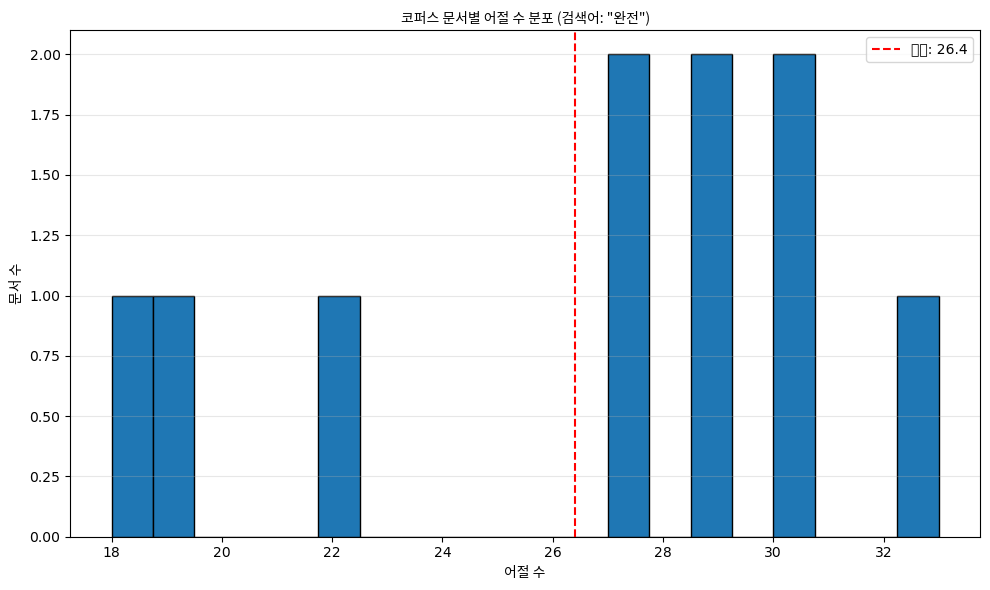


✓ 그래프 저장 완료: ../data/my_first_corpus/docs/word_count_distribution.png


In [12]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정 
font_path = os.path.abspath('../fonts/NotoSansCJKkr-Regular.otf')
fontprop = fm.FontProperties(fname=font_path)

plt.rcParams['axes.unicode_minus'] = False

# 통계 출력
print("코퍼스 통계")
print("=" * 50)
print(f"총 문서 수: {len(metadata_df):,}개")
print(f"총 어절 수: {metadata_df['word_count'].sum():,}개")
print(f"평균 어절 수: {metadata_df['word_count'].mean():.1f}개")
print(f"중앙값: {metadata_df['word_count'].median():.1f}개")
print(f"최소: {metadata_df['word_count'].min()}개")
print(f"최대: {metadata_df['word_count'].max()}개")

# 어절 수 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(metadata_df['word_count'], bins=20, edgecolor='black')
plt.xlabel('어절 수', fontproperties=fontprop)
plt.ylabel('문서 수', fontproperties=fontprop)
plt.title(f'코퍼스 문서별 어절 수 분포 (검색어: "{SEARCH_QUERY}")', fontproperties=fontprop)
plt.axvline(metadata_df['word_count'].mean(), color='red', 
            linestyle='--', label=f'평균: {metadata_df["word_count"].mean():.1f}'
            )
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f'{DATA_FOLDER}/{CORPUS_NAME}/docs/word_count_distribution.png', dpi=300)
plt.show()

print(f"\n✓ 그래프 저장 완료: {DATA_FOLDER}/{CORPUS_NAME}/docs/word_count_distribution.png")

## 12. 시간별 분포 확인

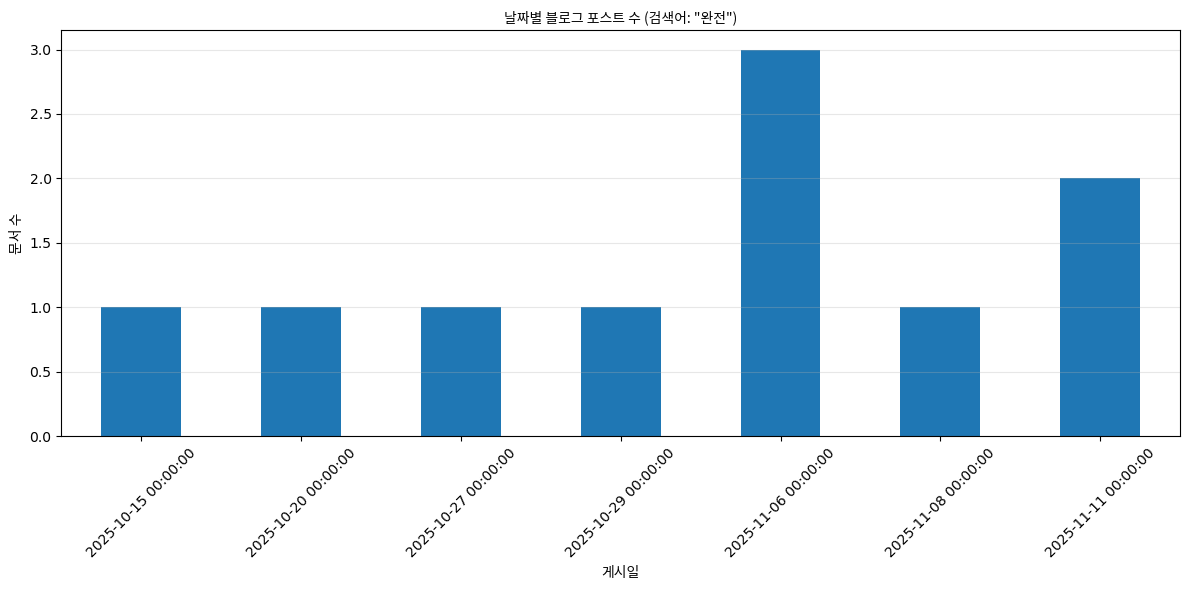

✓ 그래프 저장 완료: ../data/my_first_corpus/docs/temporal_distribution.png


In [13]:
# 날짜 형식 변환
metadata_df['post_date_converted'] = pd.to_datetime(metadata_df['post_date'], format='%Y%m%d')

# 날짜별 문서 수
date_counts = metadata_df['post_date_converted'].value_counts().sort_index()

# 시각화
plt.figure(figsize=(12, 6))
date_counts.plot(kind='bar')
plt.xlabel('게시일', fontproperties=fontprop)
plt.ylabel('문서 수', fontproperties=fontprop)
plt.title(f'날짜별 블로그 포스트 수 (검색어: "{SEARCH_QUERY}")', fontproperties=fontprop)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f'{DATA_FOLDER}/{CORPUS_NAME}/docs/temporal_distribution.png', dpi=300)
plt.show()

print(f"✓ 그래프 저장 완료: {DATA_FOLDER}/{CORPUS_NAME}/docs/temporal_distribution.png")

## 13. 전체 코퍼스 요약

In [14]:
def print_corpus_summary(corpus_name, metadata_df):
    """
    코퍼스 요약 정보 출력
    """
    print("\n" + "="*60)
    print(f"코퍼스 구축 완료: {corpus_name}")
    print("="*60)
    
    print("\n📊 통계 정보:")
    print(f"  - 총 문서 수: {len(metadata_df):,}개")
    print(f"  - 총 어절 수: {metadata_df['word_count'].sum():,}개")
    print(f"  - 평균 어절 수: {metadata_df['word_count'].mean():.1f}개")
    
    print("\n📁 생성된 파일:")
    print(f"  - README.md")
    print(f"  - LICENSE.txt")
    print(f"  - metadata.csv")
    print(f"  - raw/{len(metadata_df)}개 텍스트 파일")
    print(f"  - docs/word_count_distribution.png")
    print(f"  - docs/temporal_distribution.png")
    
    print("\n✅ 다음 단계:")
    print("  1. README.md를 열어 코퍼스 정보 확인")
    print("  2. metadata.csv를 열어 메타데이터 확인")
    print("  3. raw/ 폴더에서 텍스트 파일 확인")
    print("  4. Git으로 버전 관리 시작:")
    print(f"     cd {DATA_FOLDER}/{corpus_name}")
    print("     git init")
    print("     git add .")
    print('     git commit -m "Initial commit: v1.0"')
    print("="*60 + "\n")

# 요약 출력
print_corpus_summary(CORPUS_NAME, metadata_df)


코퍼스 구축 완료: my_first_corpus

📊 통계 정보:
  - 총 문서 수: 10개
  - 총 어절 수: 264개
  - 평균 어절 수: 26.4개

📁 생성된 파일:
  - README.md
  - LICENSE.txt
  - metadata.csv
  - raw/10개 텍스트 파일
  - docs/word_count_distribution.png
  - docs/temporal_distribution.png

✅ 다음 단계:
  1. README.md를 열어 코퍼스 정보 확인
  2. metadata.csv를 열어 메타데이터 확인
  3. raw/ 폴더에서 텍스트 파일 확인
  4. Git으로 버전 관리 시작:
     cd ../data/my_first_corpus
     git init
     git add .
     git commit -m "Initial commit: v1.0"

